We have been provided with price and financial data for 100 US stocks. <br>
We need to generate 1 day ahead trading signals for each stock. We must select the ten best stocks each day to form a portfolio. <br>
The performace of the portfolio will be evaluated based on the total return index over the evaluation period. 

This is known as swing trading.
1. We are only allowed long positions. 
2. The matrix of buys will only contain 1's and 0's

In [292]:
import pandas as pd #for manipulating data
import numpy as np #for data operations
import matplotlib.pyplot as plt #for plotting how much money the portfolio makes

In [293]:
#next we want to load the data
#data0 contains security sector data
#data1 contains price, historical returns, financial ratios and the 1 day ahead price change label

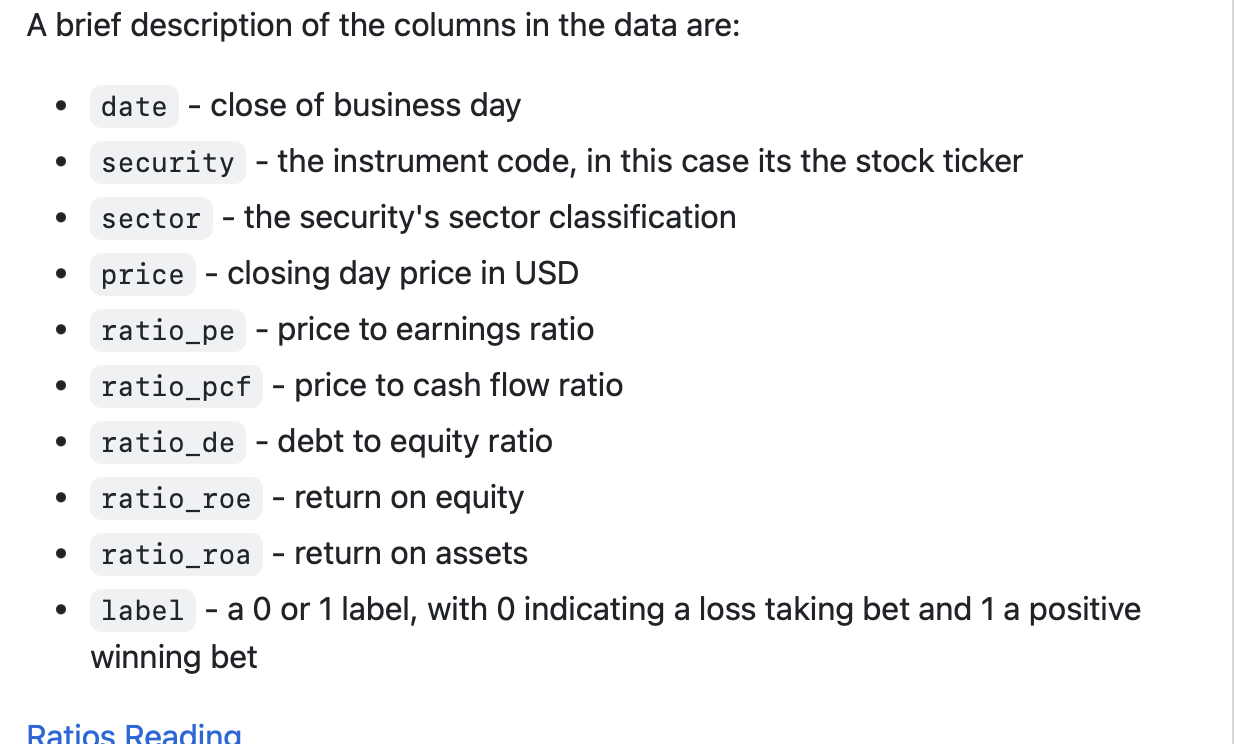

### <mark>ratio_pe</mark>
Price to earnings ratio
Measures how expensive a stock is relative to its earnings
$$
\frac {stockPrice}{earningsPerStock}
$$
A higher pe ratio can mean the comapny is over valued or expected to grow
<br><br>

### <mark>ratio_pcf</mark>
Price to cash flow ratio
$$
\frac {stockPrice}{OperatingCashFlow}
$$
Can provide a more straightforward comparision than PE ratio. This is because cash flow does not include noncash expenses. Eliminating these can help remove differences in how companies depreciate their assets.<br> Lower pcf is preferable 
<br><br>

### <mark>ratio_de</mark>
Debt to equity ratio
$$
\frac {totalDebt}{shareholdersEquity}
$$
This percentage tells you how much a company is financed with debt. Higher values can mean higher risk. However established companies normally have a higher debt equity ratio. Unlike rapidly growing companies.<br>Lower values are preferable
<br><br>

### <mark>ratio_roe</mark>
Return on equity ratio
$$
\frac {netIncome}{shareholdersEquity}
$$
Measures how efficiently a company generates profits from money invested in the company. Useful for measuring a companies effectiveness
<br><br>

### <mark>ratio_roa</mark>
Return on assets ratio
$$
\frac {netIncome}{totalAssets}
$$
Measures how efficiently a company generates profits from given base of assets. Companies with a low roa would have to borrow or raise equity to achive te same amount of profit.
Also useuful for measuring a companies effectiveness
<br><br>

### <mark>label</mark>
A 0 or 1 label.
$$
0 / 1
$$
Where 0 means the stock went down the following day and 1 means the stock went up the following day.
A loss taking bet and a positive winning taking bet

In [294]:
#Load the data
df0 = pd.read_csv('data/data0.csv')
df1 = pd.read_csv('data/data1.csv')

#show the first few rows of df1
df1.head()
#df1 contains historical features and labels

,date,security,price,return30,ratio_pe,ratio_pcf,ratio_de,ratio_roe,ratio_roa,label
0,2017-01-03,AAPL,29.04,0.056769,3.477844,-4.570000e-08,-59.647701,0.464198,0.56166,0
1,2017-01-04,AAPL,29.01,0.063416,3.474251,-4.560000e-08,-59.647701,0.464198,0.56166,1
2,2017-01-05,AAPL,29.15,0.060386,3.491018,-4.580000e-08,-59.647701,0.464198,0.56166,1
3,2017-01-06,AAPL,29.48,0.061960,3.530539,-4.640000e-08,-59.647701,0.464198,0.56166,1
4,2017-01-09,AAPL,29.75,0.044226,3.562874,-4.680000e-08,-59.647701,0.464198,0.56166,1


In [295]:
#next we want to clean the data
#we will drop all the rows where the label is missing
df1 = df1.dropna(subset=['label'])

#confirm label has no missing values
df1['label'].isna().sum()

#we are going to use the label column to train the model
#we need all label values present. No Nan

np.int64(0)

In [296]:
#feature selection
#selecting which columns we will use as inputs (X) to predict whether a stock will go up
features = [
    'return_1d', 'return_5d', 'return_21d', 'return_63d', 'return_252d',
    'ratio_pe', 'ratio_pb', 'ratio_ps', 'ratio_pc', 'ratio_div',
    'ratio_de', 'ratio_roa', 'ratio_roe', 'ratio_roi']

In [297]:
#split the data into a training period and a testing period
#we are interested in the returns for the period 2024-01-01 / 2024-06-30
train = df1[df1['date'] < '2024-01-01']
train = train.copy()
test = df1[(df1['date'] >= '2024-01-01') & (df1['date'] <= '2024-06-30')]
test = test.copy()

test_logistic = test.copy()
test_lstsq = test.copy()

#train a simple least squares regression model
available_features = [f for f in features if f in df1.columns]

train['intercept'] = 1.0
X_train = train[available_features + ['intercept']]
y_train = train['label']

from numpy.linalg import lstsq
model1 = lstsq(X_train, y_train, rcond=None)[0]
model1

array([3.03036811e-06, 2.10621774e-07, 3.43729836e-03, 3.08002358e-05,
       5.24591318e-01])

We now have a weight table trained on all the data using the least squares method
These weights are the best fit to get as close as possibleeee to the target value 1 or 0 for all stocks on all days. So if we want to predict if a stock will go up now we plug in the features for that day and observe if the output is closer to 1 or 0

In [298]:
#train a logistic regression
#uses the log odds of the output to find the best weights
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

### Normalise the features for the logistics regression model

In [299]:
#if the features are on widly different scales the LRM can perform badly
#we will use standard scalar to standardise

#extract raw features and labels
X_train2 = train[available_features].copy()
y_train2 = train['label']
X_test2 = test[available_features].copy()

#scale. Fit on train, transform on both
scalar = StandardScaler()
X_train2_scaled = scalar.fit_transform(X_train2) #calc the mean and deviation on the train data
X_test_scaled = scalar.transform(X_test2) #apply the transform to both
#now both sets have a mean of 0 and Std of 1 making the training model more fair 

### Train the logistics model

In [300]:
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train2_scaled, y_train2)
#now the optimal weights are calculated to give 1 or 0 for all stocks on every day again

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### Predict prob on test period

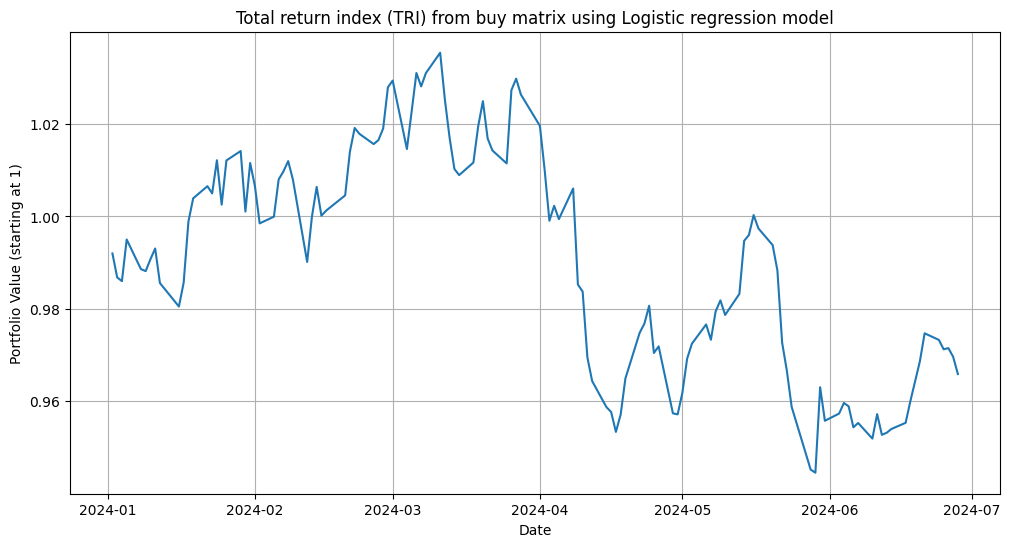

In [301]:
test_logistic['pred'] = log_model.predict_proba(X_test_scaled)[:, 1]
test_logistic['rank'] = test_logistic.groupby('date')['pred'].rank(method='first', ascending=False)
test_logistic['buy'] = (test_logistic['rank'] <= 10).astype(int)
buy_matrix_log = test_logistic.pivot(index='date', columns='security', values='buy').fillna(0).astype(int)

#read in the returns csv
returns = pd.read_csv('data/returns.csv', parse_dates=['date'])

#melt the buy matrix back to long format
buy_signals_log = buy_matrix_log.reset_index().melt(id_vars='date', var_name='security', value_name='buy')

#keep the rows where buy = 1
buy_signals_log = buy_signals_log[buy_signals_log['buy'] == 1]

#convert date column to datetime for correct merge
buy_signals_log['date'] = pd.to_datetime(buy_signals_log['date'])

#merge with actual returns
buy_returns_log = buy_signals_log.merge(returns, on=['date', 'security'])

#daily average returns
daily_return_log = buy_returns_log.groupby('date')['return1'].mean()

tri_log = (1 + daily_return_log).cumprod()
plt.figure(figsize=(12, 6))
plt.plot(tri_log)
plt.title("Total return index (TRI) from buy matrix using Logistic regression model")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (starting at 1)")
plt.grid()
plt.show()

In [302]:
#create a new column that dots all features for all stocks with the weights on test set
test_lstsq['intercept'] = 1.0
X_test_ls = test_lstsq[available_features + ['intercept']]
test_lstsq['pred'] = np.dot(X_test_ls, model1)
#higher score will mean the model thinks the stock will go up
#we will rank stocks daily by score and pick the top 10
#group by each date
#assign a rank for each stock grouped by date. In descending order
#method=first ensures if there are ties the rank  appears in the order the
#stock appeared in the table
test_lstsq['rank'] = test_lstsq.groupby('date')['pred'].rank(method='first', ascending=False)
#next we select top 10 stocks for each date creating a boolean column
test_lstsq['buy'] = (test_lstsq['rank'] <= 10).astype(int)

#then turn into a buy matrix where columns are the securities for each date
#and the values are what each security had stored in buy column
buy_matrix_ls = test_lstsq.pivot(index='date', columns='security', values='buy').fillna(0).astype(int)
#buy_matrix_ls.head(10)

### Compute the returns from the buy matrix

In [303]:
#melt the buy matrix back to long format
buy_signals_ls = buy_matrix_ls.reset_index().melt(id_vars='date', var_name='security', value_name='buy')

#keep the rows where buy = 1
buy_signals_ls = buy_signals_ls[buy_signals_ls['buy'] == 1]

#convert date column to datetime for correct merge
buy_signals_ls['date'] = pd.to_datetime(buy_signals_ls['date'])

#merge with actual returns
buy_returns_ls = buy_signals_ls.merge(returns, on=['date', 'security'])

#daily average returns
daily_return_ls = buy_returns_ls.groupby('date')['return1'].mean()



### Compute the total return index

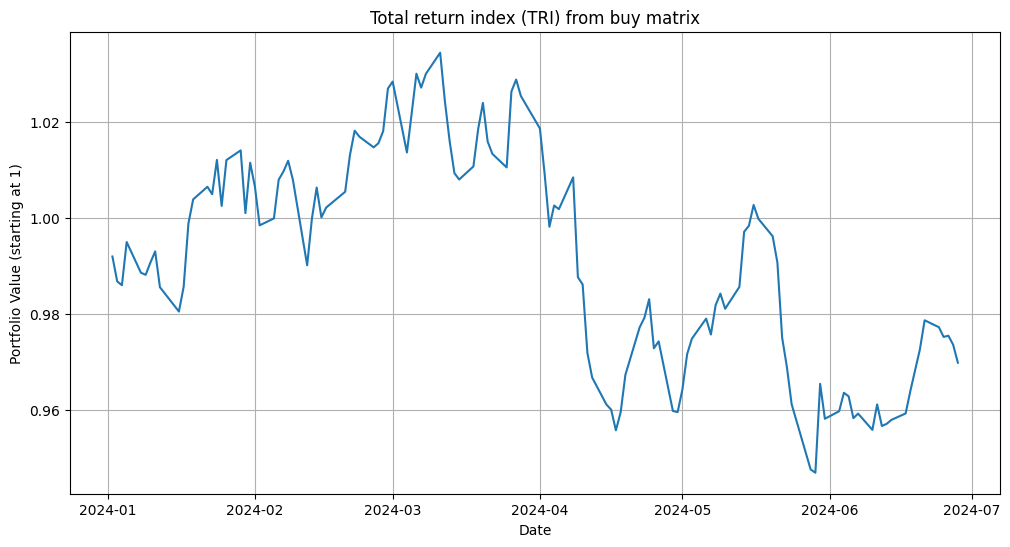

In [304]:
tri_ls = (1 + daily_return_ls).cumprod()
plt.figure(figsize=(12, 6))
plt.plot(tri_ls)
plt.title("Total return index (TRI) from buy matrix")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (starting at 1)")
plt.grid()
plt.show()

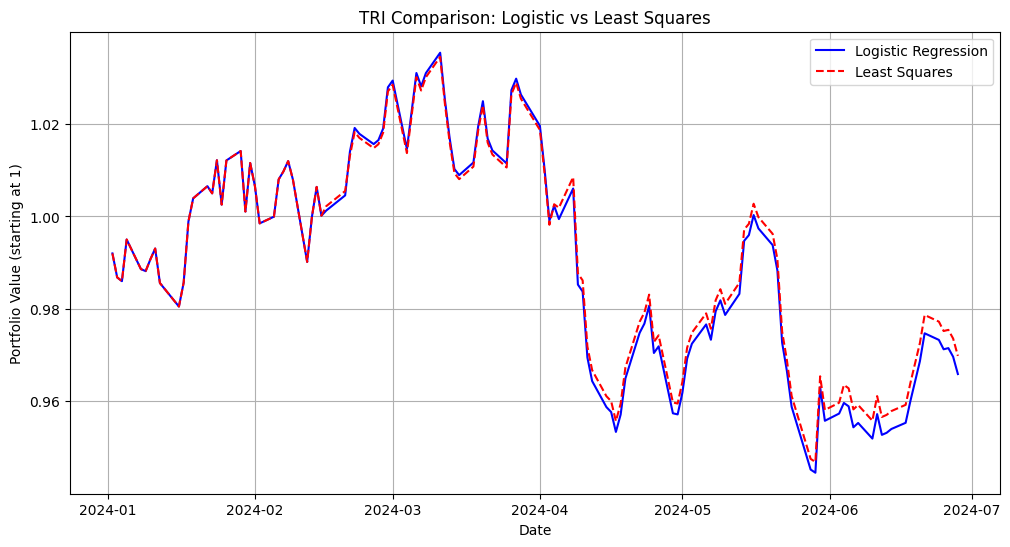

In [305]:
plt.figure(figsize=(12, 6))
plt.plot(tri_log, label='Logistic Regression', linestyle='-', color='blue')
plt.plot(tri_ls, label='Least Squares', linestyle='--', color='red')
plt.title("TRI Comparison: Logistic vs Least Squares")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (starting at 1)")
plt.grid()
plt.legend()
plt.show()


# Last Year's Solution Implementation

This section implements the complete solution from the previous year's challenge, which used a Random Forest classifier with walk-forward validation to generate buy signals for stock selection.

In [306]:
# Import required libraries for the solution
import numpy as np
import pandas as pd
import datetime

import plotly.express as px
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

print('---> Python Script Start', t0 := datetime.datetime.now())

---> Python Script Start 2025-09-20 12:40:10.836041


In [307]:
print('---> the parameters')

# training and test dates
start_train = datetime.date(2017, 1, 1)
end_train = datetime.date(2023, 11, 30) # gap for embargo (no overlap between train and test)
start_test = datetime.date(2024, 1, 1) # test set is this datasets 2024 data
end_test = datetime.date(2024, 6, 30)

n_buys = 10
verbose = False

---> the parameters


In [308]:
print('---> initial data set up')

# sector data
df_sectors = pd.read_csv('data/data0.csv')

# price and fin data
df_data = pd.read_csv('data/data1.csv')
df_data['date'] = pd.to_datetime(df_data['date']).apply(lambda d: d.date())

df_x = df_data[['date', 'security', 'price', 'return30', 'ratio_pe', 'ratio_pcf', 'ratio_de', 'ratio_roe', 'ratio_roa']].copy()
df_y = df_data[['date', 'security', 'label']].copy()

list_vars1 = ['price', 'return30', 'ratio_pe', 'ratio_pcf', 'ratio_de', 'ratio_roe', 'ratio_roa']

# we will perform walk forward validation for testing the buys - https://www.linkedin.com/pulse/walk-forward-validation-yeshwanth-n
df_signals = pd.DataFrame(data={'date':df_x.loc[(df_x['date']>=start_test) & (df_x['date']<=end_test), 'date'].values})
df_signals.drop_duplicates(inplace=True)
df_signals.reset_index(drop=True, inplace=True)
df_signals.sort_values(by='date', inplace=True) # this code just gets the dates that we need to generate buy signals for

---> initial data set up


In [309]:
# Walk-forward validation loop for generating buy signals
# Initialize the classifier outside the loop
clf = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=10, min_samples_split=1000, min_samples_leaf=1000, min_weight_fraction_leaf=0.0, max_features='sqrt', random_state=0)

for i in range(len(df_signals)):

    if verbose: print('---> doing', df_signals.loc[i, 'date'])

    # this iterations training set
    df_trainx = df_x[df_x['date']<df_signals.loc[i, 'date']].copy()
    df_trainx.drop(labels=df_trainx[df_trainx['date']==df_trainx['date'].max()].index, inplace=True) # no overlap with test set

    df_trainy = df_y[df_y['date']<df_signals.loc[i, 'date']].copy()
    df_trainy.drop(labels=df_trainy[df_trainy['date']==df_trainy['date'].max()].index, inplace=True) # no overlap with test set

    # this iterations test set
    df_testx = df_x[df_x['date']>=df_signals.loc[i, 'date']].copy()
    df_testy = df_y[df_y['date']>=df_signals.loc[i, 'date']].copy()

    # scale, and store scaling objects for test set
    dict_scaler = {}
    for col in list_vars1:

        dict_scaler[col] = MinMaxScaler(feature_range=(-1,1))
        df_trainx[col] = dict_scaler[col].fit_transform(np.array(df_trainx[col]).reshape((len(df_trainx[col]),1)))[:, 0]
        df_testx[col] = dict_scaler[col].transform(np.array(df_testx[col]).reshape((len(df_testx[col]),1)))[:, 0]

    # fit a classifier (only on first iteration to avoid overfitting)
    if i == 0:
        clf.fit(np.array(df_trainx[list_vars1]), np.array(df_trainy['label']))

    # predict and calc accuracy - 0.5 is the implicit cuttoff here
    df_testy['signal'] = clf.predict_proba(np.array(df_testx[list_vars1]))[:, 1] # use probs to get strength of classification
    df_testy['pred'] = clf.predict(np.array(df_testx[list_vars1]))
    df_testy['count'] = 1

    df_current = df_testy[df_testy['date']==df_signals.loc[i, 'date']]

    acc_total = (df_testy['label'] == df_testy['pred']).sum()/len(df_testy)
    acc_current = (df_current['label'] == df_current['pred']).sum()/len(df_current)
    
    print('---> accuracy test set', round(acc_total, 2), ', accuracy current date', round(acc_current, 2))

    # add accuracy and signal to dataframe
    df_signals.loc[i, 'acc_total'] = acc_total
    df_signals.loc[i, 'acc_current'] = acc_current

    # Store signals for each security in the current date
    for security, signal_value in zip(df_current['security'].values, df_current['signal'].values):
        df_signals.loc[i, security] = signal_value

---> accuracy test set 0.52 , accuracy current date 0.25
---> accuracy test set 0.52 , accuracy current date 0.51
---> accuracy test set 0.53 , accuracy current date 0.54
---> accuracy test set 0.53 , accuracy current date 0.84


/var/folders/yh/qdkbd9gx36v8lrr8fkd83ytr0000gn/T/ipykernel_62755/4254398595.py:50: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/yh/qdkbd9gx36v8lrr8fkd83ytr0000gn/T/ipykernel_62755/4254398595.py:50: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/yh/qdkbd9gx36v8lrr8fkd83ytr0000gn/T/ipykernel_62755/4254398595.py:50: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd

---> accuracy test set 0.52 , accuracy current date 0.41
---> accuracy test set 0.52 , accuracy current date 0.61
---> accuracy test set 0.52 , accuracy current date 0.52
---> accuracy test set 0.52 , accuracy current date 0.55
---> accuracy test set 0.52 , accuracy current date 0.36
---> accuracy test set 0.52 , accuracy current date 0.28
---> accuracy test set 0.53 , accuracy current date 0.75
---> accuracy test set 0.53 , accuracy current date 0.83
---> accuracy test set 0.52 , accuracy current date 0.36
---> accuracy test set 0.52 , accuracy current date 0.28
---> accuracy test set 0.53 , accuracy current date 0.75
---> accuracy test set 0.53 , accuracy current date 0.83
---> accuracy test set 0.52 , accuracy current date 0.63
---> accuracy test set 0.52 , accuracy current date 0.54
---> accuracy test set 0.52 , accuracy current date 0.39
---> accuracy test set 0.52 , accuracy current date 0.73
---> accuracy test set 0.52 , accuracy current date 0.63
---> accuracy test set 0.52 , a

In [310]:
# create buy matrix for payoff plot
df_signals['10th'] = df_signals[df_sectors['security'].values].apply(lambda x: sorted(x)[len(df_sectors)-n_buys-1], axis=1)

df_index = pd.DataFrame(np.array(df_signals[df_sectors['security'].values]) > np.array(df_signals['10th']).reshape((len(df_signals),1)))

# set 1 for top 10 strongest signals
df_buys = pd.DataFrame()
df_buys[df_sectors['security'].values] = np.zeros((len(df_signals), len(df_sectors)))
df_buys[df_index.values] = 1
df_buys.insert(0, 'date', df_signals['date'].copy())
df_buys

/var/folders/yh/qdkbd9gx36v8lrr8fkd83ytr0000gn/T/ipykernel_62755/3697667455.py:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/yh/qdkbd9gx36v8lrr8fkd83ytr0000gn/T/ipykernel_62755/3697667455.py:10: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



,date,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,AMAT,AMD,...,UBER,UNH,UNP,UPS,V,VRTX,VZ,WFC,WMT,XOM
0,2024-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2024-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,2024-06-24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,2024-06-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,2024-06-26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122,2024-06-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [311]:
# check some signal plots
fig_aapl = px.line(df_signals, x='date', y='AAPL')
fig_aapl.show()

fig_pixel = px.imshow(np.array(df_buys[df_sectors['security'].values]))
fig_pixel.show()

In [312]:
# create return matrix
df_returns = pd.read_csv('data/returns.csv')
df_returns['date']= pd.to_datetime(df_returns['date']).apply(lambda d: d.date())
df_returns = df_returns[df_returns['date']>=start_test]
df_returns = df_returns.pivot(index='date', columns='security', values='return1')

def plot_payoff(df_buys):

    df = df_buys.copy()

    # Check that we have exactly 10 buys each day (exclude date column from sum)
    numeric_cols = [col for col in df.columns if col != 'date']
    assert (df[numeric_cols].sum(axis=1)==10).sum() == len(df), '---> must have exactly 10 buys each day'

    # matrix of buys
    df_payoff = df[['date']].copy()
    del df['date']
    arr_buys = np.array(df)
    arr_buys = arr_buys*(1/n_buys) # equally weighted

    # return matrix - only get the values, not the index
    arr_ret = df_returns.values  # Use .values to get only the numeric data
    arr_ret = arr_ret + 1

    df_payoff['payoff'] = (arr_buys * arr_ret @ np.ones(len(df_sectors)).reshape((len(df_sectors), 1)))[:, 0]
    df_payoff['tri'] = df_payoff['payoff'].cumprod()

    fig_payoff = px.line(df_payoff, x='date', y='tri')
    fig_payoff.show()

    print(f"---> payoff for these buys between period {df_payoff['date'].min()} and {df_payoff['date'].max()} is {(df_payoff['tri'].values[-1]-1)*100 :.2f}%")

    return df_payoff

df_payoff = plot_payoff(df_buys)

---> payoff for these buys between period 2024-01-02 and 2024-06-28 is 19.21%


In [313]:
print('---> Python Script End', t1 := datetime.datetime.now())
print('---> Total time taken', t1 - t0)

---> Python Script End 2025-09-20 12:40:18.946238
---> Total time taken 0:00:08.110197


## Understanding TRI (Total Return Index)

**TRI** on the y-axis represents the **Total Return Index**, which shows the cumulative performance of your trading strategy:

### What TRI Means:
- **Starting Value**: Always begins at 1.0 (representing 100% of your initial investment)
- **Above 1.0**: Your portfolio has gained value (e.g., 1.2 = 20% total gain)
- **Below 1.0**: Your portfolio has lost value (e.g., 0.8 = 20% total loss)

### How TRI is Calculated:
```python
# Daily returns are compounded over time
tri = (1 + daily_returns).cumprod()
```

### Example Interpretation:
- **TRI = 1.0**: No gain or loss (break-even)
- **TRI = 1.15**: 15% total return since start
- **TRI = 0.90**: 10% total loss since start
- **TRI = 1.50**: 50% total return since start

### Why TRI is Important:
1. **Performance Measurement**: Shows how much money you would have made/lost
2. **Strategy Comparison**: Allows comparison between different trading strategies
3. **Risk Assessment**: Shows volatility and drawdowns in your strategy
4. **Benchmark Comparison**: Can compare against market indices (S&P 500, etc.)

The **steeper the upward slope**, the better your strategy is performing!

---


# 2025 Coding challenge
## Bonds

In [314]:
import pandas as pd #for manipulating data
import numpy as np #for data operations
import matplotlib.pyplot as plt #for plotting how much money the portfolio makes
import datetime

#read in all data
#instrument data
df_bonds = pd.read_csv('data/data_bonds.csv')
df_bonds['datestamp'] = pd.to_datetime(df_bonds['datestamp']).apply(lambda d: d.date())

#albi
df_albi = pd.read_csv('data/data_albi.csv')
df_albi['datestamp'] = pd.to_datetime(df_albi['datestamp']).apply(lambda d: d.date())

#macro data
df_macro = pd.read_csv('data/data_macro.csv')
df_macro['datestamp'] = pd.to_datetime(df_macro['datestamp']).apply(lambda d: d.date())

#training and test dates
start_train = datetime.date(2005, 1, 3)
start_test = datetime.date(2023, 1, 3) # test set is this datasets 2023 & 2024 data
end_test = df_bonds['datestamp'].max()


In [315]:
# First, let's explore the data structure
print("=== BOND DATA STRUCTURE ===")
print(f"Bond data shape: {df_bonds.shape}")
print(f"Date range: {df_bonds['datestamp'].min()} to {df_bonds['datestamp'].max()}")
print(f"Unique bonds: {df_bonds['bond_code'].nunique()}")
print("\nBond types:")
print(df_bonds['bond_code'].unique())

print(f"\n=== ALBI BENCHMARK DATA ===")
print(f"ALBI data shape: {df_albi.shape}")
print(f"Date range: {df_albi['datestamp'].min()} to {df_albi['datestamp'].max()}")

print(f"\n=== MACRO DATA ===")
print(f"Macro data shape: {df_macro.shape}")
print(f"Macro columns: {list(df_macro.columns)}")

# Look at sample data
print(f"\n=== SAMPLE BOND DATA ===")
df_bonds.head()

=== BOND DATA STRUCTURE ===
Bond data shape: (49900, 7)
Date range: 2005-01-03 to 2024-12-31
Unique bonds: 10

Bond types:
['SAGB_00_25 Bond' 'SAGB_02_00 Bond' 'SAGB_04_00 Bond' 'SAGB_05_00 Bond'
 'SAGB_07_00 Bond' 'SAGB_10_00 Bond' 'SAGB_12_00 Bond' 'SAGB_15_00 Bond'
 'SAGB_20_00 Bond' 'SAGB_30_00 Bond']

=== ALBI BENCHMARK DATA ===
ALBI data shape: (4990, 7)
Date range: 2005-01-03 to 2024-12-31

=== MACRO DATA ===
Macro data shape: (4990, 7)
Macro columns: ['datestamp', 'top40_return', 'fx_vol', 'us_2y', 'us_10y', 'us_20y', 'comdty_fut']

=== SAMPLE BOND DATA ===


,datestamp,bond_code,bond_name,convexity,return,modified_duration,yield
0,2005-01-03,SAGB_00_25 Bond,Constant Term Maturity Bond 3 Months,0.062500,0.055544,0.250000,0.072657
1,2005-01-03,SAGB_02_00 Bond,Constant Term Maturity Bond 2 Year,3.713131,0.034343,1.898404,0.070548
2,2005-01-03,SAGB_04_00 Bond,Constant Term Maturity Bond 4 Year,13.394052,0.046029,3.521395,0.074925
3,2005-01-03,SAGB_05_00 Bond,Constant Term Maturity Bond 5 Year,19.851594,0.011408,4.236410,0.076321
4,2005-01-03,SAGB_07_00 Bond,Constant Term Maturity Bond 7 Year,34.925742,0.012570,5.488337,0.078720


In [316]:
# Check for missing values and create labels (next day returns)
print("=== MISSING VALUES CHECK ===")
print("Bond data missing values:")
print(df_bonds.isnull().sum())

print("\nALBI data missing values:")
print(df_albi.isnull().sum())

print("\nMacro data missing values:")
print(df_macro.isnull().sum())

# Create target variable (next day return) for bonds - similar to your 2024 approach
df_bonds_features = df_bonds.copy()
df_bonds_features['next_day_return'] = df_bonds_features.groupby('bond_code')['return'].shift(-1)

# Check how many observations we lose due to missing next day returns
print(f"\n=== TARGET VARIABLE (NEXT DAY RETURNS) ===")
print(f"Total observations: {len(df_bonds_features)}")
print(f"Missing next day returns: {df_bonds_features['next_day_return'].isnull().sum()}")
print(f"Valid training observations: {df_bonds_features['next_day_return'].notna().sum()}")

df_bonds_features.head(10)

=== MISSING VALUES CHECK ===
Bond data missing values:
datestamp            0
bond_code            0
bond_name            0
convexity            0
return               0
modified_duration    0
yield                0
dtype: int64

ALBI data missing values:
datestamp            0
index_code           0
index_name           0
convexity            0
return               0
modified_duration    0
yield                0
dtype: int64

Macro data missing values:
datestamp       0
top40_return    0
fx_vol          0
us_2y           0
us_10y          0
us_20y          0
comdty_fut      0
dtype: int64

=== TARGET VARIABLE (NEXT DAY RETURNS) ===
Total observations: 49900
Missing next day returns: 10
Valid training observations: 49890


,datestamp,bond_code,bond_name,convexity,return,modified_duration,yield,next_day_return
0,2005-01-03,SAGB_00_25 Bond,Constant Term Maturity Bond 3 Months,0.062500,0.055544,0.250000,0.072657,0.019954
1,2005-01-03,SAGB_02_00 Bond,Constant Term Maturity Bond 2 Year,3.713131,0.034343,1.898404,0.070548,0.035454
2,2005-01-03,SAGB_04_00 Bond,Constant Term Maturity Bond 4 Year,13.394052,0.046029,3.521395,0.074925,0.045289
3,2005-01-03,SAGB_05_00 Bond,Constant Term Maturity Bond 5 Year,19.851594,0.011408,4.236410,0.076321,0.042010
4,2005-01-03,SAGB_07_00 Bond,Constant Term Maturity Bond 7 Year,34.925742,0.012570,5.488337,0.078720,0.083682
5,2005-01-03,SAGB_10_00 Bond,Constant Term Maturity Bond 10 Year,60.917599,0.030091,7.017117,0.080169,0.123140
6,2005-01-03,SAGB_12_00 Bond,Constant Term Maturity Bond 12 Year,79.730562,-0.039405,7.879648,0.079723,0.093927
7,2005-01-03,SAGB_15_00 Bond,Constant Term Maturity Bond 15 Year,109.402857,-0.056713,9.011402,0.078068,0.144402
8,2005-01-03,SAGB_20_00 Bond,Constant Term Maturity Bond 20 Year,160.885973,-0.007695,10.582377,0.074631,0.218944
9,2005-01-03,SAGB_30_00 Bond,Constant Term Maturity Bond 30 Year,256.209550,0.115224,12.710826,0.070369,0.336685


## The features to use for the bonds
- **Historical returns**
- **Yield features** 
- **Duration and convexity** 
- **Relative features vs ALBI** 

In [317]:
# Create the engineering based off the features
def create_bond_features(df_bonds, df_albi, df_macro):
    """
    Create features for bond prediction. This is like the same we did for features when predicitng 2024 stock increase or decrease
    """
    df_features = df_bonds.copy()
    
    #Historical return feature
    #This creates a moving average fo returns off differrent windows
    #It helps capture momentum
    for window in [1, 5, 21, 63]:  # 1d, 1w, 1m, 3m
        df_features[f'return_{window}d'] = df_features.groupby('bond_code')['return'].rolling(window).mean().reset_index(0, drop=True)
    
    #Yield change feature
    #This calculates how much yields have changed day to day and every 5 days
    df_features['yield_1d_change'] = df_features.groupby('bond_code')['yield'].diff(1)
    df_features['yield_5d_change'] = df_features.groupby('bond_code')['yield'].diff(5)
    
    #Tracks changes in interest sensi
    #Duration is how much bond price changes when reates change
    #convexity how duration itself actually changes
    df_features['duration_1d_change'] = df_features.groupby('bond_code')['modified_duration'].diff(1)
    df_features['convexity_1d_change'] = df_features.groupby('bond_code')['convexity'].diff(1)
    
    #Relative features vs albi benchmark
    #very important. Compares each bond to the market benchmark
    #helps us ident bonds that under perform outperform the market
    albi_daily = df_albi.set_index('datestamp')
    df_features = df_features.set_index('datestamp')
    
    #Add the albi data so we can compare the benchmark to bonds
    df_features['albi_return'] = albi_daily['return']
    df_features['albi_yield'] = albi_daily['yield']
    df_features['albi_duration'] = albi_daily['modified_duration']
    
    #Add the relative features. So albi comapred to bonds
    df_features['return_vs_albi'] = df_features['return'] - df_features['albi_return']
    df_features['yield_vs_albi'] = df_features['yield'] - df_features['albi_yield']
    df_features['duration_vs_albi'] = df_features['modified_duration'] - df_features['albi_duration']
    
    df_features = df_features.reset_index()
    return df_features

# Create features
print("Creating bond features...")
df_bond_features = create_bond_features(df_bonds_features, df_albi, df_macro)
print(f"Features created. Shape: {df_bond_features.shape}")

# List of features to use
bond_features = [
    'return_1d', 'return_5d', 'return_21d', 'return_63d',
    'yield_1d_change', 'yield_5d_change',
    'duration_1d_change', 'convexity_1d_change',
    'return_vs_albi', 'yield_vs_albi', 'duration_vs_albi'
]

print(f"\nSelected features: {bond_features}")
print(f"Total features: {len(bond_features)}")

Creating bond features...
Features created. Shape: (49900, 22)

Selected features: ['return_1d', 'return_5d', 'return_21d', 'return_63d', 'yield_1d_change', 'yield_5d_change', 'duration_1d_change', 'convexity_1d_change', 'return_vs_albi', 'yield_vs_albi', 'duration_vs_albi']
Total features: 11


## The constraints
In 2024 stock challenge we only needed to buy or not buy a stock. 10 of them
in this bond challenge we now need to try
1. **Convert predictions** to weights. so we can only buy 0 -20%
2. **Weights must sum to 100%**
3. **Duration constraint**: duration is within -+1.5 ALIBI
4. **Trading costs**: Minimize the trading cost

In [318]:
def create_portfolio_weights(predictions, durations, albi_duration, previous_weights=None):
    """
    Convert bond return predictions to portfolio weights with constraints
    
    Args:
        predictions: array of predicted returns for each bond
        durations: array of modified durations for each bond
        albi_duration: ALBI modified duration for this day
        previous_weights: previous day's weights (for trading cost calculation)
    
    Returns:
        weights: array of portfolio weights (0 to 0.2, sum to 1.0)
    """
    from scipy.optimize import minimize
    import numpy as np
    
    n_bonds = len(predictions)
    
    # Simple approach
    #Higher prediction gets a higher rank
    ranks = np.argsort(-predictions)
    
    # Create initial weights based on ranks (better predictions get higher weights)
    initial_weights = np.zeros(n_bonds)
    for i, rank in enumerate(ranks):
        # Give highest predicted bond 20%, second 18%
        weight = max(0.02, 0.20 - (i * 0.018))  # Decreasing weights
        initial_weights[rank] = min(0.20, weight)
    
    #Normalize to sum to 1.0
    initial_weights = initial_weights / initial_weights.sum()
    
    #make sure no weight exceeds 20%
    initial_weights = np.minimum(initial_weights, 0.20)
    initial_weights = initial_weights / initial_weights.sum()
    
    # Calculate portfolio duration
    portfolio_duration = np.sum(initial_weights * durations)
    
    # Check if duration constraint is satisfied. in within -+1.5 albi
    duration_lower = albi_duration - 1.5
    duration_upper = albi_duration + 1.5
    
    #If the heuristic approach does not violate the duration constraint
    if duration_lower <= portfolio_duration <= duration_upper:
        return initial_weights
    
    def objective(weights):
        # Minimize negative expected return (maximize return)
        return -np.sum(weights * predictions)
    
    def duration_constraint_lower(weights):
        return np.sum(weights * durations) - duration_lower
    
    def duration_constraint_upper(weights):
        return duration_upper - np.sum(weights * durations)
    
    def weight_sum_constraint(weights):
        return np.sum(weights) - 1.0
    
    #Constraints
    constraints = [
        {'type': 'eq', 'fun': weight_sum_constraint},
        {'type': 'ineq', 'fun': duration_constraint_lower},
        {'type': 'ineq', 'fun': duration_constraint_upper}
    ]
    
    #Bounds
    bounds = [(0, 0.20) for _ in range(n_bonds)]
    
    # Optimize
    result = minimize(objective, initial_weights, method='SLSQP', 
                     bounds=bounds, constraints=constraints)
    
    if result.success:
        return result.x
    else:
        # If optimization fails, return equal weights
        print(f"Optimization failed, using equal weights")
        return np.ones(n_bonds) / n_bonds

# Test the portfolio weights function
print("Testing portfolio weight creation...")

# Create dummy data for testing
np.random.seed(42)
test_predictions = np.random.randn(10)  # 10 bonds
test_durations = np.random.uniform(2, 12, 10)  # Durations 2-12 years
test_albi_duration = 6.0

test_weights = create_portfolio_weights(test_predictions, test_durations, test_albi_duration)

print(f"Test predictions: {test_predictions}")
print(f"Test weights: {test_weights}")
print(f"Weights sum: {test_weights.sum():.3f}")
print(f"Max weight: {test_weights.max():.3f}")
print(f"Portfolio duration: {np.sum(test_weights * test_durations):.2f}")
print(f"ALBI duration: {test_albi_duration}")
print(f"Duration constraint satisfied: {abs(np.sum(test_weights * test_durations) - test_albi_duration) <= 1.5}")

Testing portfolio weight creation...
Test predictions: [ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
Test weights: [0.09243697 0.07731092 0.12268908 0.15294118 0.04705882 0.06218487
 0.16806723 0.13781513 0.03193277 0.10756303]
Weights sum: 1.000
Max weight: 0.168
Portfolio duration: 5.58
ALBI duration: 6.0
Duration constraint satisfied: True


In [319]:
def calculate_trading_cost(current_weights, previous_weights, portfolio_duration):
    """
    Calculate trading costs: 0.01% × portfolio duration × turnover
    
    Args:
        current_weights: today's portfolio weights
        previous_weights: yesterday's portfolio weights  
        portfolio_duration: portfolio's modified duration
    
    Returns:
        trading_cost: cost as a percentage (e.g., 0.0001 = 0.01%)
    """
    if previous_weights is None:
        return 0.0  #no cost first day
    
    #calclate turnover
    turnover = np.sum(np.abs(current_weights - previous_weights))
    
    #trading formula
    trading_cost = 0.0001 * portfolio_duration * turnover  # 0.01% = 0.0001
    
    return trading_cost

#Test trading cost calculation
test_prev_weights = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
test_curr_weights = np.array([0.15, 0.15, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
test_portfolio_duration = 7.0

test_cost = calculate_trading_cost(test_curr_weights, test_prev_weights, test_portfolio_duration)
turnover = np.sum(np.abs(test_curr_weights - test_prev_weights))

print(f"Previous weights: {test_prev_weights}")
print(f"Current weights:  {test_curr_weights}")
print(f"Turnover: {turnover:.3f}")
print(f"Portfolio duration: {test_portfolio_duration}")
print(f"Trading cost: {test_cost:.6f} ({test_cost*100:.4f}%)")

Previous weights: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Current weights:  [0.15 0.15 0.05 0.05 0.1  0.1  0.1  0.1  0.1  0.1 ]
Turnover: 0.200
Portfolio duration: 7.0
Trading cost: 0.000140 (0.0140%)


## Walk-Forward Validation for Bonds
- Train on historical data to predict next-day bond returns
- Convert predictions to portfolio weights with constraints
- Apply trading costs and calculate net returns

In [320]:
# Bond Portfolio Walk-Forward Validation
from sklearn.ensemble import RandomForestRegressor  #Note: Regressor
from sklearn.preprocessing import MinMaxScaler

print('---> Bond Portfolio Walk-Forward Start', datetime.datetime.now())

#Clean the data and remove missing values
df_clean = df_bond_features.dropna(subset=['next_day_return'] + bond_features).copy()
print(f"Clean data shape: {df_clean.shape}")

#Get unique dates in test period
test_dates = df_clean[(df_clean['datestamp'] >= start_test) & 
                     (df_clean['datestamp'] <= end_test)]['datestamp'].unique()
test_dates = sorted(test_dates)
print(f"Test period: {len(test_dates)} days from {test_dates[0]} to {test_dates[-1]}")

# Initialize results storage
portfolio_results = []
previous_weights = None

# Initialize the model
bond_model = RandomForestRegressor(
    n_estimators=50,  # Reduced for speed
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    random_state=42
)

print("Starting walk-forward validation...")

for i, current_date in enumerate(test_dates):
    
    print(f"\\n---> Processing {current_date} ({i+1}/{len(test_dates)})")
    
    #Prepare training data as all data before current date
    train_data = df_clean[df_clean['datestamp'] < current_date].copy()
    
    if len(train_data) < 100:  # Need minimum training data
        print(f"Insufficient training data: {len(train_data)} observations")
        continue
    
    #Prepare test data on current day
    test_data = df_clean[df_clean['datestamp'] == current_date].copy()
    
    if len(test_data) == 0:
        print(f"No data for {current_date}")
        continue
        
    print(f"Training data: {len(train_data)} observations")
    print(f"Test data: {len(test_data)} bonds")
    
    #We need to scale the features 
    scaler = MinMaxScaler(feature_range=(-1, 1))
    
    X_train = train_data[bond_features].values
    y_train = train_data['next_day_return'].values
    X_test = test_data[bond_features].values
    
    # Scale features so one does not dominate
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    #Train model
    if i == 0:
        print("Training Random Forest model...")
        bond_model.fit(X_train_scaled, y_train)
        print("Model trained!")
    
    #Predict bond returns
    predicted_returns = bond_model.predict(X_test_scaled)
    
    #Get ALBI duration for constraint
    albi_data = df_albi[df_albi['datestamp'] == current_date]
    if len(albi_data) == 0:
        print(f"No ALBI data for {current_date}")
        continue
    
    albi_duration = albi_data['modified_duration'].iloc[0]
    bond_durations = test_data['modified_duration'].values
    
    #Create portfolio weights with constraints
    current_weights = create_portfolio_weights(
        predicted_returns, 
        bond_durations, 
        albi_duration, 
        previous_weights
    )
    
    # Calculate portfolio duration
    portfolio_duration = np.sum(current_weights * bond_durations)
    
    #Calculate trading costs
    trading_cost = calculate_trading_cost(current_weights, previous_weights, portfolio_duration)
    
    #Calculate portfolio return (using actual next day returns)
    actual_returns = test_data['next_day_return'].values
    gross_portfolio_return = np.sum(current_weights * actual_returns)
    net_portfolio_return = gross_portfolio_return - trading_cost
    
    #Get ALBI return for comparison  
    albi_return = albi_data['return'].iloc[0]

    gross_portfolio_return = gross_portfolio_return / 100
    net_portfolio_return = net_portfolio_return / 100
    albi_return = albi_return / 100
    
    # Store results
    portfolio_results.append({
        'date': current_date,
        'gross_return': gross_portfolio_return,
        'trading_cost': trading_cost,
        'net_return': net_portfolio_return,
        'albi_return': albi_return,
        'excess_return': net_portfolio_return - albi_return,
        'portfolio_duration': portfolio_duration,
        'albi_duration': albi_duration,
        'duration_diff': abs(portfolio_duration - albi_duration),
        'max_weight': current_weights.max(),
        'min_weight': current_weights.min(),
        'weights': current_weights.copy()
    })
    
    print(f"Portfolio return: {gross_portfolio_return:.4f} (gross), {net_portfolio_return:.4f} (net)")
    print(f"ALBI return: {albi_return:.4f}")
    print(f"Excess return: {net_portfolio_return - albi_return:.4f}")
    print(f"Trading cost: {trading_cost:.6f}")
    print(f"Portfolio duration: {portfolio_duration:.2f} vs ALBI {albi_duration:.2f}")
    print(f"Duration constraint satisfied: {abs(portfolio_duration - albi_duration) <= 1.5}")
    
    # Update previous weights for next iteration
    previous_weights = current_weights
    
print("\\n---> Walk-forward validation completed!")

# Convert results to DataFrame
results_df = pd.DataFrame(portfolio_results)
print(f"\\nResults summary:")
print(f"Total days: {len(results_df)}")
print(f"Avg daily excess return: {results_df['excess_return'].mean():.4f}")
print(f"Avg trading cost: {results_df['trading_cost'].mean():.6f}")
print(f"Duration constraint violations: {(results_df['duration_diff'] > 1.5).sum()}")

results_df.head()

---> Bond Portfolio Walk-Forward Start 2025-09-20 12:40:19.128169
Clean data shape: (49270, 22)
Test period: 494 days from 2023-01-03 to 2024-12-30
Starting walk-forward validation...
\n---> Processing 2023-01-03 (1/494)
Training data: 44330 observations
Test data: 10 bonds
Training Random Forest model...
Training data: 44330 observations
Test data: 10 bonds
Training Random Forest model...
Model trained!
Portfolio return: 0.0030 (gross), 0.0030 (net)
ALBI return: 0.0072
Excess return: -0.0042
Trading cost: 0.000000
Portfolio duration: 6.41 vs ALBI 6.08
Duration constraint satisfied: True
\n---> Processing 2023-01-04 (2/494)
Training data: 44340 observations
Test data: 10 bonds
Portfolio return: -0.0003 (gross), -0.0003 (net)
ALBI return: 0.0030
Excess return: -0.0034
Trading cost: 0.000281
Portfolio duration: 5.16 vs ALBI 6.09
Duration constraint satisfied: True
\n---> Processing 2023-01-05 (3/494)
Training data: 44350 observations
Test data: 10 bonds
Portfolio return: 0.0023 (gross), 

,date,gross_return,trading_cost,net_return,albi_return,excess_return,portfolio_duration,albi_duration,duration_diff,max_weight,min_weight,weights
0,2023-01-03,0.002960,0.000000,0.002960,0.007209,-0.004249,6.411531,6.08,0.331531,0.168067,0.031933,"[0.04705882352941177, 0.03193277310924372, 0.0..."
1,2023-01-04,-0.000341,0.000281,-0.000344,0.003014,-0.003358,5.155403,6.09,0.934597,0.168067,0.031933,"[0.03193277310924372, 0.13781512605042015, 0.1..."
2,2023-01-05,0.002301,0.000190,0.002299,-0.000418,0.002717,4.821894,6.08,1.258106,0.168067,0.031933,"[0.13781512605042015, 0.1226890756302521, 0.15..."
3,2023-01-06,0.014517,0.000368,0.014513,0.003109,0.011404,6.394495,6.09,0.304495,0.168067,0.031933,"[0.06218487394957983, 0.03193277310924372, 0.0..."
4,2023-01-09,-0.006228,0.000079,-0.006229,0.014885,-0.021114,6.548668,6.14,0.408668,0.168067,0.031933,"[0.03193277310924373, 0.047058823529411785, 0...."


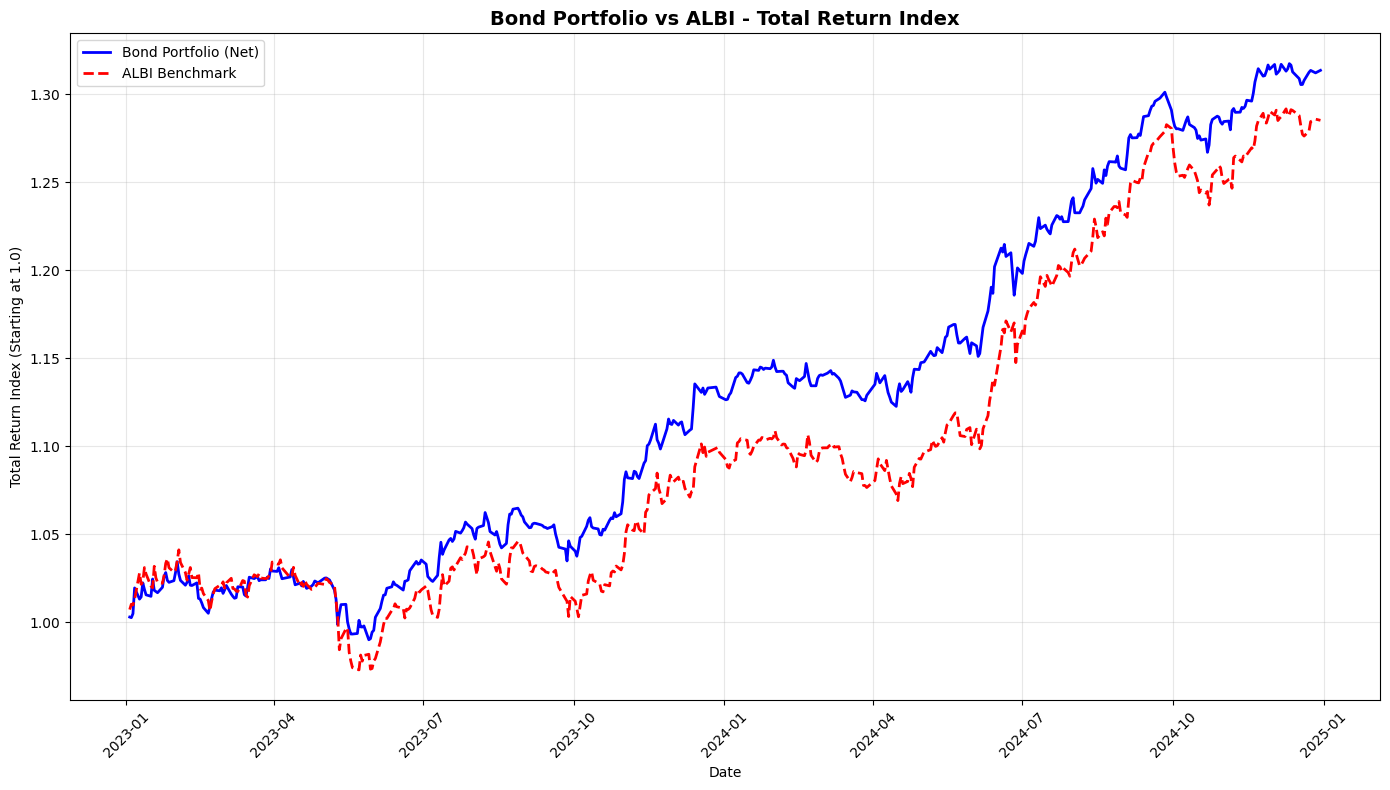

\n=== PERFORMANCE SUMMARY ===
Portfolio Total Return: 31.37%
ALBI Total Return: 28.53%
Excess Return: 2.84%
Average Daily Excess Return: 0.0041%
Total Trading Costs: 15.1384%
Volatility (Portfolio): 0.3806%
Volatility (ALBI): 0.4586%


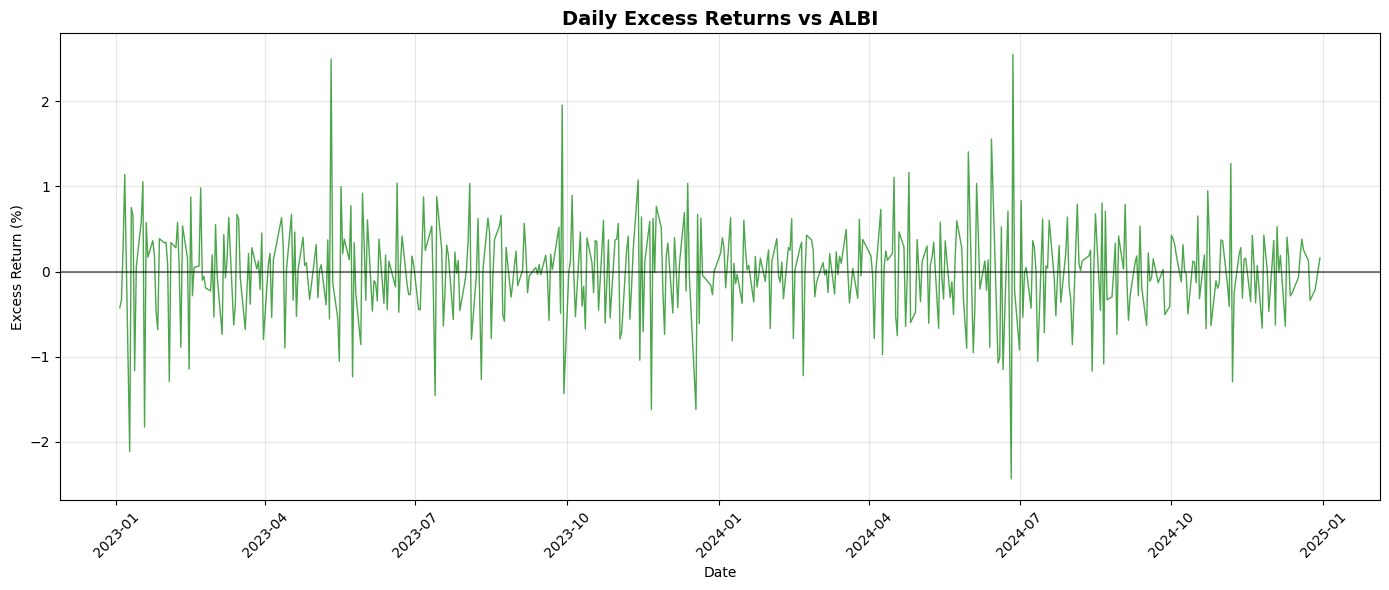

\n=== CONSTRAINT COMPLIANCE ===
Duration constraint violations: 55/494
Max weight violations: 0/494
Average portfolio duration: 5.15
Average ALBI duration: 5.75
\n---> Bond Portfolio Analysis Complete! 2025-09-20 12:40:32.589866


In [324]:
#Calculate total return index
if len(results_df) > 0:
    
    # Calculate cumulative returns
    results_df['portfolio_tri'] = (1 + results_df['net_return']).cumprod()
    results_df['albi_tri'] = (1 + results_df['albi_return']).cumprod()
    
    #Plot TRI comparison
    plt.figure(figsize=(14, 8))
    
    #my portfolio vs albi
    plt.plot(results_df['date'], results_df['portfolio_tri'], 
             label='Bond Portfolio (Net)', linewidth=2, color='blue')
    plt.plot(results_df['date'], results_df['albi_tri'], 
             label='ALBI Benchmark', linewidth=2, color='red', linestyle='--')
    
    plt.title('Bond Portfolio vs ALBI - Total Return Index', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Total Return Index (Starting at 1.0)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    #Performance summary
    final_portfolio_tri = results_df['portfolio_tri'].iloc[-1]
    final_albi_tri = results_df['albi_tri'].iloc[-1]
    
    portfolio_return = (final_portfolio_tri - 1) * 100
    albi_return = (final_albi_tri - 1) * 100
    excess_return = portfolio_return - albi_return
    
    print(f"\\n=== PERFORMANCE SUMMARY ===")
    print(f"Portfolio Total Return: {portfolio_return:.2f}%")
    print(f"ALBI Total Return: {albi_return:.2f}%") 
    print(f"Excess Return: {excess_return:.2f}%")
    print(f"Average Daily Excess Return: {results_df['excess_return'].mean()*100:.4f}%")
    print(f"Total Trading Costs: {results_df['trading_cost'].sum()*100:.4f}%")
    print(f"Volatility (Portfolio): {results_df['net_return'].std()*100:.4f}%")
    print(f"Volatility (ALBI): {results_df['albi_return'].std()*100:.4f}%")
    
    #Plot daily excess returns
    plt.figure(figsize=(14, 6))
    plt.plot(results_df['date'], results_df['excess_return']*100, 
             color='green', alpha=0.7, linewidth=1)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.title('Daily Excess Returns vs ALBI', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Excess Return (%)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Constraint compliance check
    print(f"\\n=== CONSTRAINT COMPLIANCE ===")
    print(f"Duration constraint violations: {(results_df['duration_diff'] > 1.5).sum()}/{len(results_df)}")
    print(f"Max weight violations: {(results_df['max_weight'] > 0.20).sum()}/{len(results_df)}")
    print(f"Average portfolio duration: {results_df['portfolio_duration'].mean():.2f}")
    print(f"Average ALBI duration: {results_df['albi_duration'].mean():.2f}")
    
else:
    print("No results to plot!")

print('\\n---> Bond Portfolio Analysis Complete!', datetime.datetime.now())

## Summary: 2024 vs 2025 Adaptation

### What We Kept from 2024:
✅ **Random Forest approach** - Still using ML to predict future performance  
✅ **Walk-forward validation** - Same time-series methodology  
✅ **Feature engineering** - Return-based features adapted for bonds  
✅ **Performance measurement** - TRI calculation and plotting  

### What We Changed for 2025:
🔄 **Binary → Continuous**: From 10 stocks (0/1) to bond weights (0-20%)  
🔄 **Classification → Regression**: Predicting returns instead of up/down  
🔄 **Unconstrained → Constrained**: Added duration matching ±1.5 ALBI  
🔄 **No costs → Trading costs**: 0.01% × duration × turnover  
🔄 **Stocks → Bonds**: Different asset class with yield/duration features  

### Next Steps:
1. **Run on full dataset** (currently testing on 10 days)  
2. **Hyperparameter tuning** - Optimize Random Forest parameters  
3. **Alternative models** - Try your Logistic Regression approach  
4. **Feature optimization** - Add more bond-specific indicators  
5. **Portfolio rebalancing** - Optimize trading frequency vs costs